In [2]:
using Dates
using JuMP
using CSV
using DataFrames
using LinearAlgebra
using Distributions
using Statistics
using Dates
using Plots
ENV["COLUMNS"] = 200;
include("COVIDResourceAllocation.jl")
using .COVIDResourceAllocation

In [54]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
start_date = Date(2020, 3, 30)
end_date   = Date(2020, 6, 30)
travel_threshold_hours = 4.0

adj = adjacencies(states, level=:state, source=:google, threshold=travel_threshold_hours);

In [55]:
hospitalized_days = 14
forecast_initial = forecast(
    states, start_date-Dates.Day(1), start_date-Dates.Day(1),
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
)[:]
forecast_active = forecast(
    states, start_date, end_date,
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
)
forecast_admitted = forecast(
    states, start_date, end_date,
    level=:state,
    source=:ihme,
    forecast_type=:admitted,
    patient_type=:regular,
    bound_type=:mean,
)
forecast_discharged = forecast(
    states, start_date-Dates.Day(hospitalized_days), start_date-Dates.Day(1),
    level=:state,
    source=:ihme,
    forecast_type=:admitted,
    patient_type=:regular,
    bound_type=:mean,
);

In [61]:
pct_nurses_available = 0.5
patients_per_nurse_covid = 2.5
nurse_hrs_per_week_covid = 36
pct_beds_available = 0.25

beds = n_beds(states, bed_type=:all, pct_beds_available=pct_beds_available)

N = length(states);
T = (end_date - start_date).value + 1

forecast_discharged = hcat(forecast_discharged, zeros(Float32, N, T - hospitalized_days))

@show nurse_hrs_per_day_covid = nurse_hrs_per_week_covid / 7
@show nurses_days_per_day_covid = 24 / nurse_hrs_per_day_covid

@show nurse_days_per_patient_day_covid = nurses_days_per_day_covid / patients_per_nurse_covid;

nurses = n_nurses(states) * Float32(pct_nurses_available);
demand = forecast_active * Float32(nurse_days_per_patient_day_covid);

nurse_hrs_per_day_covid = nurse_hrs_per_week_covid / 7 = 5.142857142857143
nurses_days_per_day_covid = 24 / nurse_hrs_per_day_covid = 4.666666666666666
nurse_days_per_patient_day_covid = nurses_days_per_day_covid / patients_per_nurse_covid = 1.8666666666666665


In [9]:
isolation_spot = vec([7,8])
model = patient_nurse_allocation_new(
    beds,
    forecast_initial,
    forecast_discharged,
    forecast_admitted,
    nurses,
    adj,
    isolation_spot,
    los = Exponential(100),
    verbose=true
)
sentp = value.(model[:sentnurses])
sentn = value.(model[:sentpatients])
println("termination status: ", termination_status(model))
println("solve time: ", round(solve_time(model), digits=3), "s")
println("objective function value: ", round(objective_value(model), digits=3))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-21
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[x86] - Darwin 22.6.0 22G513)

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 35154 rows, 24552 columns and 5775207 nonzeros
Model fingerprint: 0x2b2fb725
Coefficient statistics:
  Matrix range     [4e-01, 2e+00]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+04]
Presolve removed 29104 rows and 6701 columns
Presolve time: 2.19s
Presolved: 6050 rows, 17851 columns, 4458329 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...


Barrier performed 0 iterations in 5.09 seconds (3.68 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Iteration    Objective       Primal Inf.    Dual Inf.      Time
    5257    1.50

In [10]:
results = PatientAllocationResults.results_all(sentp, beds, forecast_initial, forecast_admitted, forecast_discharged, states, start_date, hospitalized_days)
println("Total overflow: ", results.total_overflow)
println("Average load: ", results.average_load)

Total overflow: 0.0
Average load: -360.1231


In [11]:
results.summary_table

Row,location,total_sent,total_received,overflow,overall_load,overflow_nosent,overall_load_nosent
,String,Float64,Float64,Float64,Float64,Float32,Float32
1,CT,33606.9,32465.5,0.0,-5.48349,0.0,-5.59563
2,DE,8061.92,9705.9,557.746,-1.46198,0.0,-1.88425
3,MA,16194.9,28791.5,0.0,-2.10013,0.0,-2.49819
4,MD,34751.0,33208.8,0.0,-4.17781,0.0,-4.36704
5,ME,2845.86,2355.36,0.0,-0.393468,0.0,-0.359982
6,NH,7897.35,7413.85,0.0,-1.29917,0.0,-1.32628
7,NJ,2314.87,651.872,0.0,-6.84916,0.0,-6.79965
8,NY,11233.9,6347.19,248.064,-4.98159,0.0,-4.92251
9,PA,44099.1,40551.8,0.0,-1.77684,0.0,-1.79223


In [48]:
results_nurses = NurseAllocationResults.results_all(sentn, nurses, demand, states, start_date);

In [49]:
results_nurses.summary_table

Row,state,total_sent,total_received,initial_nurses,total_nurse_days,total_demand,total_shortage,average_load
,String,Float64,Float64,Float32,Float64,Float32,Float64,Float64
1,CT,375.287,131.232,2296.5,191282.0,1.76364e5,45816.6,0.923247
2,DE,15.4061,228.034,661.0,81255.1,19446.9,0.0,0.239348
3,MA,248.019,1054.09,5073.0,5.47025e5,1.2986e5,0.0,0.237479
4,MD,142.235,505.239,3084.5,3.20642e5,2.10661e5,0.0,0.657038
5,ME,0.0,319.316,981.0,1.20684e5,5125.24,0.0,0.0424538
6,NH,10.5682,208.549,967.0,108008.0,19925.0,0.0,0.184049
7,NJ,508.758,0.0,3326.0,2.62036e5,5.47443e5,3.0875e5,2.08931
8,NY,4064.22,0.0,9773.5,5.33064e5,7.85759e5,4.22622e5,1.47313
9,PA,0.0,2705.13,7094.5,9.09208e5,2.75288e5,0.0,0.30226


In [122]:
results_nurses.sent_matrix_table

Row,state,CT,DE,MA,MD,ME,NH,NJ,NY,PA,RI,VT
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,CT,0.0,0.0,0.0,0.0,231.671,143.616,0.0,0.0,0.0,0.0,0.0
2,DE,7.71164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.69445,0.0,0.0
3,MA,0.0,0.0,0.0,0.0,61.2619,49.7957,0.0,0.0,0.0,0.0,136.962
4,MD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,142.235,0.0,0.0
5,ME,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,NH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.5682
7,NJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,508.758,0.0,0.0
8,NY,123.52,228.034,1054.09,505.239,0.0,0.0,0.0,0.0,2046.44,106.9,0.0
9,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
s = "NJ"
contam_performance = filter(row -> row.location == s, results.complete_table)

Row,location,date,sent,received,new_patients,active_patients,active_patients_nosent,capacity,overflow,load,overflow_nosent,load_nosent,sent_to,sent_from
,String,Date,Float64,Float64,Float32,Float64,Float32,Float32,Float64,Float64,Float32,Float32,Any,Any
1,NJ,2020-03-30,0.0,651.872,19.1623,1687.4,1035.53,4553.25,0.0,0.370593,0.0,0.227427,[],"[(""CT"", 651.872)]"
2,NJ,2020-03-31,0.0,0.0,27.2138,1172.35,520.48,4553.25,0.0,0.257476,0.0,0.11431,[],[]
3,NJ,2020-04-01,0.0,0.0,34.3332,596.963,-54.9094,4553.25,0.0,0.131107,0.0,-0.0120594,[],[]
4,NJ,2020-04-02,0.0,0.0,45.6683,-34.589,-686.461,4553.25,0.0,-0.00759655,0.0,-0.150763,[],[]
5,NJ,2020-04-03,346.413,0.0,61.6248,-717.432,-1369.3,4553.25,0.0,-0.157565,0.0,-0.300731,"[(""DE"", 346.413)]",[]
6,NJ,2020-04-04,423.609,0.0,80.9276,-1789.0,-2094.46,4553.25,0.0,-0.392905,0.0,-0.459991,"[(""CT"", 361.363), (""DE"", 10.4921), (""ME"", 9.48604), (""RI"", 42.2683)]",[]
7,NJ,2020-04-05,297.129,0.0,103.17,-2976.56,-2858.41,4553.25,0.0,-0.653721,0.0,-0.627773,"[(""ME"", 9.28697), (""PA"", 287.842)]",[]
8,NJ,2020-04-06,184.153,0.0,131.107,-4062.67,-3647.39,4553.25,0.0,-0.892258,0.0,-0.801053,"[(""CT"", 180.753), (""PA"", 3.39962)]",[]
9,NJ,2020-04-07,0.0,0.0,166.104,-5049.74,-4450.31,4553.25,0.0,-1.10904,0.0,-0.977392,[],[]


In [15]:
results.sent_to

Dict{String, Vector{String}} with 11 entries:
  "RI" => ["CT", "DE", "MA", "MD", "ME", "NY", "PA", "VT"]
  "NY" => ["CT", "DE", "MA", "MD", "ME", "NH", "PA", "RI", "VT"]
  "ME" => ["CT", "DE", "MA", "MD", "NH", "PA", "VT"]
  "NJ" => ["CT", "DE", "MD", "ME", "PA", "RI"]
  "DE" => ["CT", "MA", "MD", "NH", "NY", "RI", "VT"]
  "MD" => ["CT", "DE", "MA", "ME", "NH", "NY", "PA", "RI", "VT"]
  "NH" => ["CT", "DE", "MA", "ME", "NY", "PA", "RI", "VT"]
  "CT" => ["MA", "MD", "NH", "NJ", "PA", "RI", "VT"]
  "MA" => ["CT", "DE", "MD", "ME", "NH", "PA", "RI", "VT"]
  "PA" => ["CT", "DE", "MA", "MD", "ME", "NH", "NY", "RI", "VT"]
  "VT" => ["CT", "DE", "MA", "MD", "ME", "NH", "NY", "PA", "RI"]

## Plotting overflow over time for historical data

In [63]:
# note I exlcuded the initial patients
net_patients_per_day = forecast_active-forecast_discharged+forecast_admitted;

In [64]:
nurses_p_day = (1/nurse_days_per_patient_day_covid)*pct_nurses_available*Matrix(DataFrame(repeat(nurses, 1, size(net_patients_per_day)[2]), :auto))
beds_p_day = pct_beds_available*Matrix(DataFrame(repeat(beds, 1, size(net_patients_per_day)[2]), :auto))
capacity = nurses_p_day+beds_p_day;

In [67]:
start_date = Date(2020, 3, 30)
end_date   = Date(2020, 6, 30)
overflow = net_patients_per_day - capacity
overflows_p_hosp = vec(sum(overflow, dims=1));

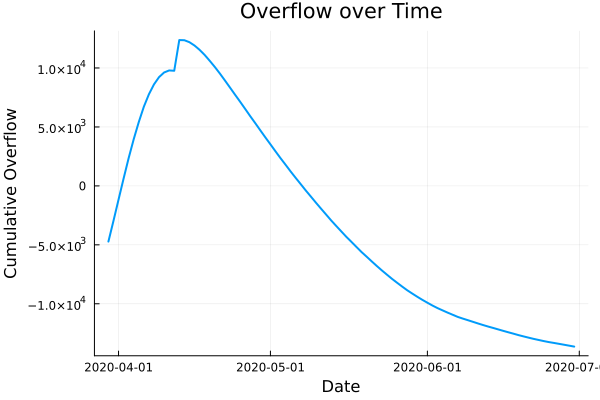

In [140]:
date_range = start_date:end_date
gr()
plot(date_range, overflows_p_hosp,
     xlabel = "Date",
     ylabel = "Cumulative Overflow",
     title = "Overflow over Time",
     legend = false,
     linewidth = 2,fmt=:png) 


In [141]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)

plot(date_range, [vec(overflow[i,:]) for i in 1:size(overflow)[1]],
     xlabel = "Date",
     ylabel = "Overflow By Hospital",
     title = "Overflow over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)
savefig(joinpath("../figures", "Historical_overflow_plot.png"))

"/Users/siyunyan/Desktop/Healthcare-Resources-Optimization-main/figures/Historical_overflow_plot.png"

In [ ]:
# total overflow overtime regardless of states
df = results.complete_table
cleaned_df = DataFrame(Date=df.date, Sent=df.sent)
# Group by state and date, then create the 11x93 matrix
grouped_df = groupby(cleaned_df, :Date)

In [160]:
df = results.complete_table
cleaned_df = DataFrame(Date=df.date, Sent=df.sent)
# Group by state and date, then create the 11x93 matrix
grouped_df = groupby(cleaned_df, :Date)

# check the shortage matrix
#size(shortage_matrix)
df = results.complete_table
cleaned_df = DataFrame(State=df.location, Date=df.date, Sent=df.sent)
# Group by state and date, then create the 11x93 matrix
grouped_df = groupby(cleaned_df, :State)
sent_matrix = zeros(11, 93)
for (i, state_df) in enumerate(grouped_df)
    sent_matrix[i, :] .= state_df.Sent
end

plot(date_range, [vec(grouped_df[i]) for i in 1:length(grouped_df)],
     xlabel = "Date",
     ylabel = "Patient Transfer By Hospital",
     title = "Total Patient Transfer Over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)
#savefig(joinpath("../figures", "PNA_PSent_plot.png"))

MethodError: MethodError: no method matching vec(::SubDataFrame{DataFrame, DataFrames.Index, Vector{Int64}})

Closest candidates are:
  vec(!Matched::Distribution{<:ArrayLikeVariate})
   @ Distributions ~/.julia/packages/Distributions/fgrZq/src/reshaped.jl:143
  vec(!Matched::FillArrays.AbstractFill)
   @ FillArrays ~/.julia/packages/FillArrays/3N7FG/src/fillalgebra.jl:3
  vec(!Matched::SparseArrays.AbstractSparseVector)
   @ SparseArrays ~/.julia/juliaup/julia-1.10.2+0.x64.apple.darwin14/share/julia/stdlib/v1.10/SparseArrays/src/sparsevector.jl:1089
  ...


## Plotting Overflow Overtime for Transfer Model

In [17]:
using Plots

s = "NJ"
df = filter(row -> row.location == s, results.complete_table)
df

Row,location,date,sent,received,new_patients,active_patients,active_patients_nosent,capacity,overflow,load,overflow_nosent,load_nosent,sent_to,sent_from
,String,Date,Float64,Float64,Float32,Float64,Float32,Float32,Float64,Float64,Float32,Float32,Any,Any
1,NJ,2020-03-30,0.0,651.872,19.1623,1687.4,1035.53,4553.25,0.0,0.370593,0.0,0.227427,[],"[(""CT"", 651.872)]"
2,NJ,2020-03-31,0.0,0.0,27.2138,1172.35,520.48,4553.25,0.0,0.257476,0.0,0.11431,[],[]
3,NJ,2020-04-01,0.0,0.0,34.3332,596.963,-54.9094,4553.25,0.0,0.131107,0.0,-0.0120594,[],[]
4,NJ,2020-04-02,0.0,0.0,45.6683,-34.589,-686.461,4553.25,0.0,-0.00759655,0.0,-0.150763,[],[]
5,NJ,2020-04-03,346.413,0.0,61.6248,-717.432,-1369.3,4553.25,0.0,-0.157565,0.0,-0.300731,"[(""DE"", 346.413)]",[]
6,NJ,2020-04-04,423.609,0.0,80.9276,-1789.0,-2094.46,4553.25,0.0,-0.392905,0.0,-0.459991,"[(""CT"", 361.363), (""DE"", 10.4921), (""ME"", 9.48604), (""RI"", 42.2683)]",[]
7,NJ,2020-04-05,297.129,0.0,103.17,-2976.56,-2858.41,4553.25,0.0,-0.653721,0.0,-0.627773,"[(""ME"", 9.28697), (""PA"", 287.842)]",[]
8,NJ,2020-04-06,184.153,0.0,131.107,-4062.67,-3647.39,4553.25,0.0,-0.892258,0.0,-0.801053,"[(""CT"", 180.753), (""PA"", 3.39962)]",[]
9,NJ,2020-04-07,0.0,0.0,166.104,-5049.74,-4450.31,4553.25,0.0,-1.10904,0.0,-0.977392,[],[]


Plot Patients Sent over Time

In [150]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)

df = results.complete_table
cleaned_df = DataFrame(State=df.location, Date=df.date, Sent=df.sent)
# Group by state and date, then create the 11x93 matrix
grouped_df = groupby(cleaned_df, :State)
sent_matrix = zeros(11, 93)
for (i, state_df) in enumerate(grouped_df)
    sent_matrix[i, :] .= state_df.Sent
end

# check the shortage matrix
#size(shortage_matrix)

plot(date_range, [vec(sent_matrix[i,:]) for i in 1:size(sent_matrix)[1]],
     xlabel = "Date",
     ylabel = "Patient Transfer By Hospital",
     title = "Total Patient Transfer Over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)
savefig(joinpath("../figures", "PNA_PSent_plot.png"))

"/Users/siyunyan/Desktop/Healthcare-Resources-Optimization-main/figures/PNA_PSent_plot.png"

In [135]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)

df = results.complete_table
cleaned_df = DataFrame(State=df.location, Date=df.date, Overflow=df.overflow)
# Group by state and date, then create the 11x93 matrix
grouped_df = groupby(cleaned_df, :State)
overflow_matrix = zeros(11, 93)
for (i, state_df) in enumerate(grouped_df)
    overflow_matrix[i, :] .= state_df.Overflow
end

# check the shortage matrix
#size(shortage_matrix)

plot(date_range, [vec(overflow_matrix[i,:]) for i in 1:size(overflow_matrix)[1]],
     xlabel = "Date",
     ylabel = "Overflow By Hospital",
     title = "Overflow over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)
savefig(joinpath("../figures", "PNA_overflow_plot.png"))

"/Users/siyunyan/Desktop/Healthcare-Resources-Optimization-main/figures/PNA_overflow_plot.png"

In [40]:
using Plots

function plot_overflow(s, results)
    df = filter(row -> row.location == s, results.complete_table)
    overflow_values = df.overflow
    days = df.date
    return plot(days, overflow_values, xlabel="Day", ylabel="Overflow", title="Total Overflow in $s over Time", legend=false)   
end

plot_overflow (generic function with 2 methods)

Contaminated hospitals

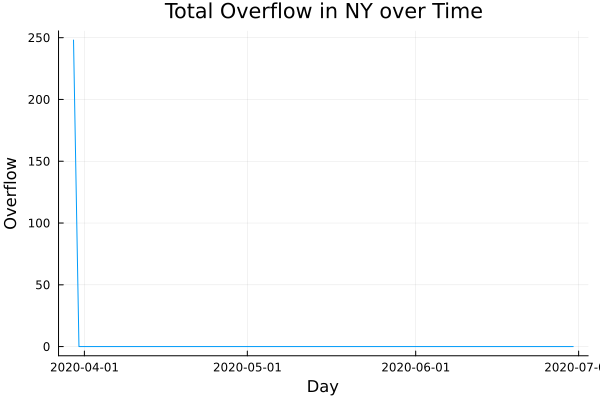

In [139]:
plot_overflow("NJ",results)
plot_overflow("NY",results)

## Shortage Plots

In [118]:
net_shortage = net_patients_per_day*nurse_days_per_patient_day_covid - nurses_p_day*pct_nurses_available;
net_shortage_p_hosp = vec(sum(net_shortage, dims=1));

In [120]:
# smoothed demand
net_shortage = demand - nurses_p_day*pct_nurses_available;
net_shortage_p_hosp = vec(sum(net_shortage, dims=1));

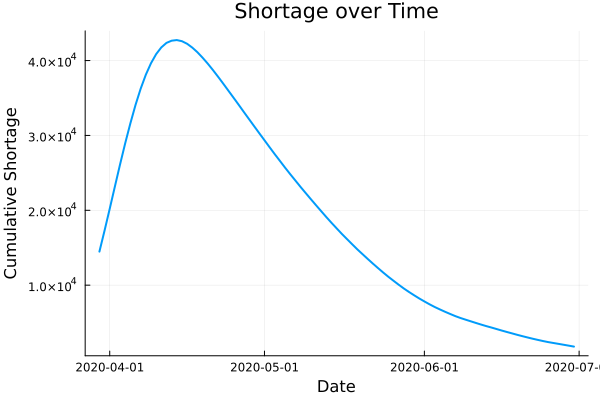

In [71]:
gr()
plot(date_range, net_shortage_p_hosp,
     xlabel = "Date",
     ylabel = "Cumulative Shortage",
     title = "Shortage over Time",
     legend = false,
     linewidth = 2,fmt=:png) 

In [121]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)

plot(date_range, [vec(net_shortage[i,:]) for i in 1:size(net_shortage)[1]],
     xlabel = "Date",
     ylabel = "Shortage By Hospital",
     title = "Shortage over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)
savefig(joinpath("../figures", "Historical_shortage_plot.png"))

"/Users/siyunyan/Desktop/Healthcare-Resources-Optimization-main/figures/Historical_shortage_plot.png"

Plot shortage over time using patient-nurse allocaiton model

In [133]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)
df = results_nurses.complete_table
cleaned_df = DataFrame(State=df.state, Date=df.date, Shortage=df.shortage)
# Group by state and date, then create the 11x93 matrix
grouped_df = groupby(cleaned_df, :State)
shortage_matrix = zeros(11, 93)
for (i, state_df) in enumerate(grouped_df)
    shortage_matrix[i, :] .= state_df.Shortage
end

# check the shortage matrix
#size(shortage_matrix)

net_shortage = shortage_matrix

plot(date_range, [vec(net_shortage[i,:]) for i in 1:size(net_shortage)[1]],
     xlabel = "Date",
     ylabel = "Shortage By Hospital",
     title = "Shortage over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)
savefig(joinpath("../figures", "PNA_shortage_plot.png"))
     

"/Users/siyunyan/Desktop/Healthcare-Resources-Optimization-main/figures/PNA_shortage_plot.png"

In [167]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)

df = results_nurses.complete_table
cleaned_df = DataFrame(State=df.state, Date=df.date, Sent=df.sent)
# Group by state and date, then create the 11x93 matrix
grouped_df = groupby(cleaned_df, :State)
sent_matrix = zeros(11, 93)
for (i, state_df) in enumerate(grouped_df)
    sent_matrix[i, :] .= state_df.Sent
end

# check the shortage matrix
#size(shortage_matrix)

plot(date_range, [vec(sent_matrix[i,:]) for i in 1:size(sent_matrix)[1]],
     xlabel = "Date",
     ylabel = "Nurse Transfer By Hospital",
     title = "Total Nurse Transfer Over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)
savefig(joinpath("../figures", "PNA_NSent_plot.png"))

"/Users/siyunyan/Desktop/Healthcare-Resources-Optimization-main/figures/PNA_NSent_plot.png"